In [2]:
import pandas as pd
df =pd.read_csv("Data2.csv")

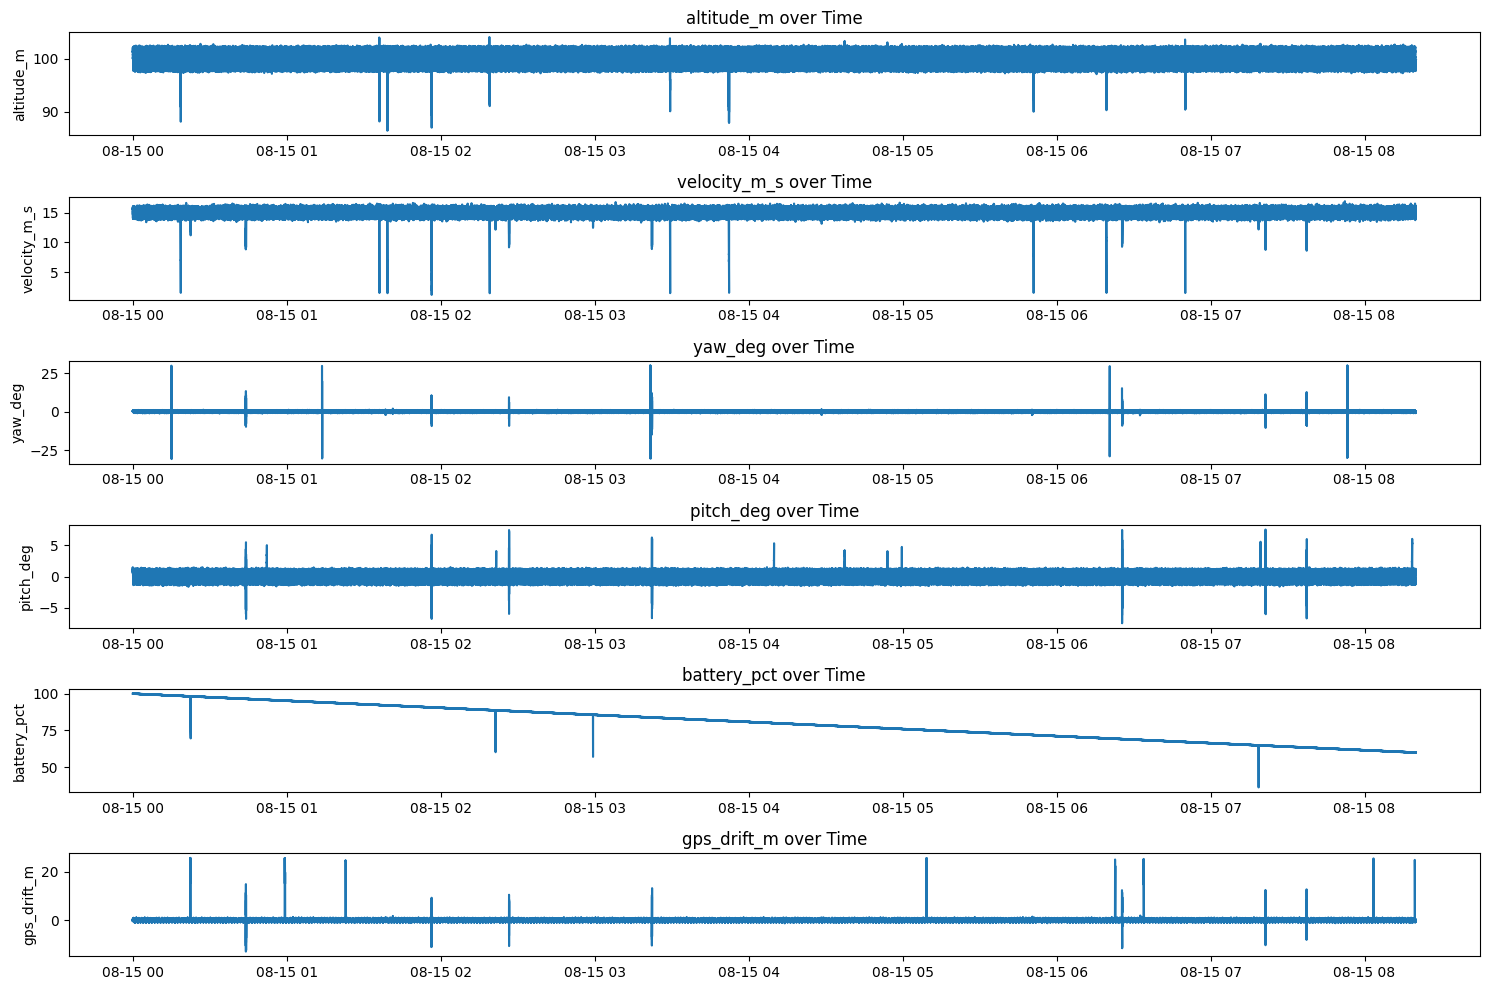

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is already loaded from the previous cell and contains the timestamp column
# Convert 'timestamp' to datetime objects
# The format string '%Y-%m-%dT%H:%M:%S.%f' accounts for the fractional seconds
df['timestamp'] = pd.to_datetime(df['timestamp'], format='mixed')

# Set 'timestamp' as the index for easier plotting
df.set_index('timestamp', inplace=True)

# Plot each feature over time
features_to_plot = ['altitude_m', 'velocity_m_s', 'yaw_deg', 'pitch_deg', 'battery_pct', 'gps_drift_m']

plt.figure(figsize=(15, 10))
for i, feature in enumerate(features_to_plot):
    plt.subplot(len(features_to_plot), 1, i + 1)
    sns.lineplot(data=df, x=df.index, y=feature)
    plt.ylabel(feature)
    plt.title(f'{feature} over Time')
    plt.xlabel('')

plt.tight_layout()
plt.show()

In [6]:
"""
Ensemble (LOF + LSTM Autoencoder) for Drone Anomaly Detection
Data schema:
  - CSV: Data2.csv ( Synthetic )
  - Features: ['altitude_m','velocity_m_s','yaw_deg','pitch_deg','battery_pct','gps_drift_m']
  - Label: anomaly_label (0=normal, 1=anomaly)
"""

# 0) TensorFlow GPU setup
import tensorflow as tf

physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    try:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        print(" TF memory growth enabled")
    except RuntimeError as e:
        print(" TF memory growth not set:", e)
else:
    print(" No GPU found by TensorFlow (will run on CPU)")


import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import classification_report, roc_auc_score, f1_score

from tensorflow.keras import layers, models, optimizers

# 1) Load & preprocess data
CSV_PATH = "Data2.csv"
FEATURES = ['altitude_m','velocity_m_s','yaw_deg','pitch_deg','battery_pct','gps_drift_m']
LABEL = 'anomaly_label'
TIMESTEPS = 10

df = pd.read_csv(CSV_PATH)
X = df[FEATURES].values.astype(np.float32)
y_point = df[LABEL].values.astype(np.int32)  # point-level labels

# scale features (same scaler for LOF & LSTM)
sclr = StandardScaler()
X_scaled = sclr.fit_transform(X).astype(np.float32)


# 3) Build sequences for LSTM
#    window label = 1 if any point in window is anomalous
def build_sequences(X_arr, y_arr, timesteps):
    X_seq, y_seq = [], []
    for i in range(len(X_arr) - timesteps + 1):
        Xw = X_arr[i:i+timesteps]
        yw = 1 if np.any(y_arr[i:i+timesteps]) else 0
        X_seq.append(Xw)
        y_seq.append(yw)
    return np.asarray(X_seq, dtype=np.float32), np.asarray(y_seq, dtype=np.int32)

X_seq, y_seq = build_sequences(X_scaled, y_point, TIMESTEPS)  # [N_seq, T, F]


# 4) LSTM Autoencoder (train on normal windows only)
normal_mask_seq = (y_seq == 0)
X_train = X_seq[normal_mask_seq]

def build_autoencoder(timesteps, n_feats):
    inp = layers.Input(shape=(timesteps, n_feats))
    x = layers.LSTM(64, activation='tanh')(inp)
    x = layers.RepeatVector(timesteps)(x)
    x = layers.LSTM(64, activation='tanh', return_sequences=True)(x)
    out = layers.TimeDistributed(layers.Dense(n_feats, activation='linear'))(x)
    model = models.Model(inp, out)
    model.compile(optimizer=optimizers.Adam(1e-3), loss='mse')
    return model

n_feats = X_seq.shape[2]
autoenc = build_autoencoder(TIMESTEPS, n_feats)

# simple train/val split on normal windows
val_size = max(1, min(2000, len(X_train)//5))
X_tr, X_val = X_train[:-val_size], X_train[-val_size:] if len(X_train) > val_size else (X_train, X_train)

print("\n=== Training LSTM Autoencoder on normal windows ===")
autoenc.fit(X_tr, X_tr,
            epochs=5,
            batch_size=128,
            validation_data=(X_val, X_val),
            verbose=1)

# reconstruction error per window
X_seq_pred = autoenc.predict(X_seq, verbose=0)
ae_scores_seq = np.mean((X_seq - X_seq_pred)**2, axis=(1,2))  # higher = more anomalous


# 5) LOF at point-level, lift to sequence-level by max over window
print("\n=== Fitting LOF on normal points ===")
lof = LocalOutlierFactor(n_neighbors=20, novelty=True)
lof.fit(X_scaled[y_point == 0])
lof_scores_point = -lof.decision_function(X_scaled)  # higher = more anomalous

# lift to sequence level (max within each window)
lof_scores_seq = np.array([
    np.max(lof_scores_point[i:i+TIMESTEPS])
    for i in range(len(X_scaled) - TIMESTEPS + 1)
], dtype=np.float32)

# 6) Normalize & combine scores
mm = MinMaxScaler()
stacked = np.vstack([ae_scores_seq, lof_scores_seq]).T  # shape [N_seq, 2]
stacked_norm = mm.fit_transform(stacked)
ae_norm = stacked_norm[:, 0]
lof_norm = stacked_norm[:, 1]

def evaluate_scores(name, scores, y_true, threshold=None):
    if threshold is None:
        threshold = np.percentile(scores, 99)  # default: top 1% anomalous
    y_pred = (scores >= threshold).astype(int)
    print(f"\n=== {name} ===")
    print(classification_report(y_true, y_pred, digits=4))
    try:
        auc = roc_auc_score(y_true, scores)
        print("ROC-AUC:", auc)
    except Exception:
        pass
    return f1_score(y_true, y_pred), threshold

# Evaluate individual models (sequence-level)
_ = evaluate_scores("Autoencoder (seq)", ae_norm, y_seq)
_ = evaluate_scores("LOF (seq, max over window)", lof_norm, y_seq)


# 7) Small grid search for best ensemble (weight & threshold)
#    weight w: ensemble = w*lof + (1-w)*AE
#    thresholds: high percentiles to control FP rate
weights = np.linspace(0.0, 1.0, 11)   # 0.0..1.0 step 0.1
percentiles = [97.5, 98.5, 99.0, 99.5]  # tune to taste

best = {"w": None, "pct": None, "f1": -1, "thr": None}
for w in weights:
    ens = w * lof_norm + (1.0 - w) * ae_norm
    for p in percentiles:
        thr = np.percentile(ens, p)
        y_pred = (ens >= thr).astype(int)
        f1 = f1_score(y_seq, y_pred)
        if f1 > best["f1"]:
            best.update({"w": w, "pct": p, "f1": f1, "thr": thr})

# final ensemble with best settings
w = best["w"]
ens = w * lof_norm + (1.0 - w) * ae_norm
print(f"\n>>> Best ensemble: w(LOF)={w:.2f}, threshold={best['pct']}th pct, F1={best['f1']:.4f}")
_ = evaluate_scores("Ensemble (LOF + AE)", ens, y_seq, threshold=best["thr"])

# 8) (Optional) Map window predictions back to points
#    Flag a point as anomaly if ANY window covering that point is anomalous.
def windows_to_points(window_scores, thr, n_points, timesteps):
    # convert window-level anomaly decision to point-level via max over covering windows
    window_flags = (window_scores >= thr).astype(int)
    point_flags = np.zeros(n_points, dtype=np.int32)
    for i, f in enumerate(window_flags):
        if f == 1:
            point_flags[i:i+timesteps] = 1
    return point_flags

# Example: point-level ensemble decisions (using best thr)
ens_flags_point = windows_to_points(ens, best["thr"], len(X_scaled), TIMESTEPS)
print("\n=== Point-level (derived from ensemble windows) ===")
print(classification_report(y_point, ens_flags_point, digits=4))
try:
    # score per point via rolling max (align with window decision smoothness)
    # For ROC-AUC at point level we create a point score as the max window score covering that point
    point_scores = np.zeros(len(X_scaled), dtype=np.float32)
    counts = np.zeros(len(X_scaled), dtype=np.int32)
    for i, s in enumerate(ens):
        point_scores[i:i+TIMESTEPS] = np.maximum(point_scores[i:i+TIMESTEPS], s)
        counts[i:i+TIMESTEPS] += 1
    print("ROC-AUC (point-level):", roc_auc_score(y_point, point_scores))
except Exception:
    pass

 TF memory growth enabled

=== Training LSTM Autoencoder on normal windows ===
Epoch 1/5
2300/2300 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - loss: 0.0841 - val_loss: 0.0420
Epoch 2/5
2300/2300 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 0.0380 - val_loss: 0.0309
Epoch 3/5
2300/2300 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 0.0273 - val_loss: 0.0220
Epoch 4/5
2300/2300 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - loss: 0.0193 - val_loss: 0.0160
Epoch 5/5
2300/2300 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 0.0150 - val_loss: 0.0141

=== Fitting LOF on normal points ===

=== Autoencoder (seq) ===
              precision    recall  f1-score   support

           0     0.9970    0.9994    0.9982    296299
           1     0.9360    0.7606    0.8392      3692

    accuracy                         0.9964    299991
   macro avg     0.9665    0.8800    0.9187    299991
weighted avg     0.9963    0.9964    0.9962    299991

ROC-AUC: 0.9335954894900479

=== LOF (seq, max over window) ===
              precision  